# Step 1: Import Data And Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud



nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/cbarank/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/cbarank/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cbarank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df = pd.read_csv("sentimentdataset.csv")

# Step 2: A Brief EDA (Exploratory Data Analyse)

In [21]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


# Step 3: Feature Engineering

### Drop unnecessary Columns

In [22]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags','Day', 'Hour','Sentiment'])

### Organizing columns and data

In [23]:
df['Platform'].value_counts()

 Instagram     258
 Facebook      231
 Twitter       128
 Twitter       115
Name: Platform, dtype: int64

In [24]:
df['Platform'] = df['Platform'].str.strip()

In [25]:
df['Platform']

0        Twitter
1        Twitter
2      Instagram
3       Facebook
4      Instagram
         ...    
727     Facebook
728    Instagram
729      Twitter
730     Facebook
731    Instagram
Name: Platform, Length: 732, dtype: object

In [26]:
df['Country'].value_counts()

 USA               59
 USA               55
 UK                49
 Canada            44
 Australia         41
                   ..
 Netherlands        1
 USA                1
 Germany            1
 France             1
 USA                1
Name: Country, Length: 115, dtype: int64

In [27]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [28]:
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

In [29]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
   
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

# Step 4: Load Data

In [30]:
df.head()

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,Clean_Text
0,Enjoying a beautiful day at the park! ...,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,January,Sunday,enjoy beauti day park
1,Traffic was terrible this morning. ...,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,January,Sunday,traffic terribl morn
2,Just finished an amazing workout! 💪 ...,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,January,Sunday,finish amaz workout
3,Excited about the upcoming weekend getaway! ...,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,January,Sunday,excit upcom weekend getaway
4,Trying out a new recipe for dinner tonight. ...,2023-01-15 19:55:00,ChefCook,Instagram,12.0,25.0,Australia,2023,January,Sunday,tri new recip dinner tonight


In [31]:
df1 = df.copy()

# Step 5: Data Analysis and Visualization

In [33]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                     Clean_Text  Vader_Score Sentiment
0         enjoy beauti day park       0.4939  positive
1          traffic terribl morn       0.0000   neutral
2           finish amaz workout       0.0000   neutral
3   excit upcom weekend getaway       0.0000   neutral
4  tri new recip dinner tonight       0.0000   neutral


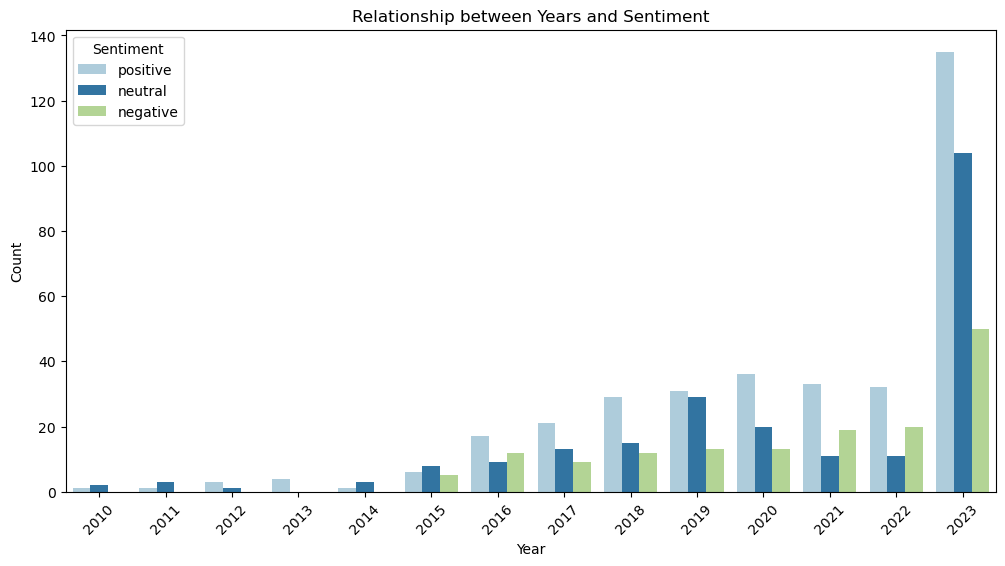

In [38]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

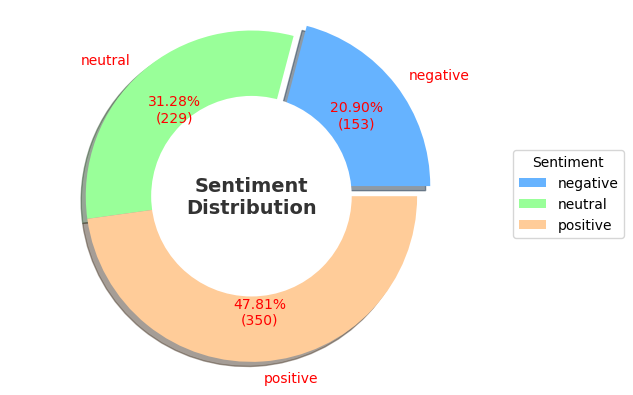

In [34]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)  

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

### Year

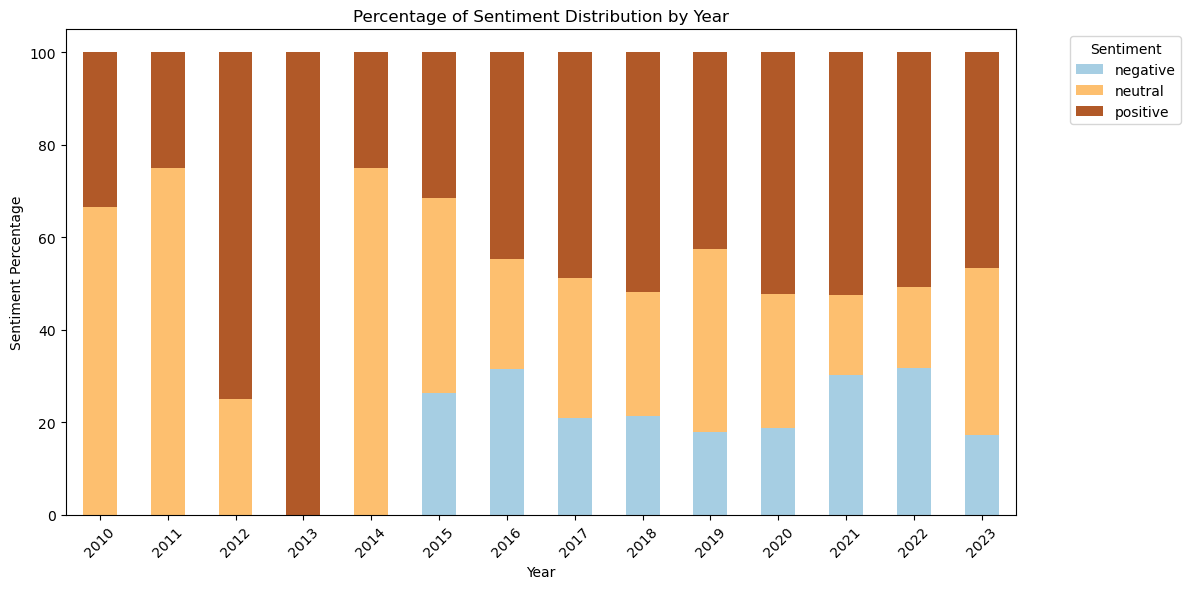

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment dağılımlarını pivotlayarak her yıl için normalize edelim
yearly_sentiment = df1.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)
yearly_sentiment_percentage = yearly_sentiment.div(yearly_sentiment.sum(axis=1), axis=0) * 100

# Grafik çizimi
plt.figure(figsize=(12, 6))
yearly_sentiment_percentage.plot(kind='bar', stacked=True, colormap='Paired', ax=plt.gca())

plt.title('Percentage of Sentiment Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Sentiment Percentage')
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [41]:
yearly_sentiment_percentage

Sentiment,negative,neutral,positive
Year,,,
2010,0.000000,66.666667,33.333333
2011,0.000000,75.000000,25.000000
2012,0.000000,25.000000,75.000000
2013,0.000000,0.000000,100.000000
2014,0.000000,75.000000,25.000000
2015,26.315789,42.105263,31.578947
2016,31.578947,23.684211,44.736842
2017,20.930233,30.232558,48.837209
2018,21.428571,26.785714,51.785714


### Month

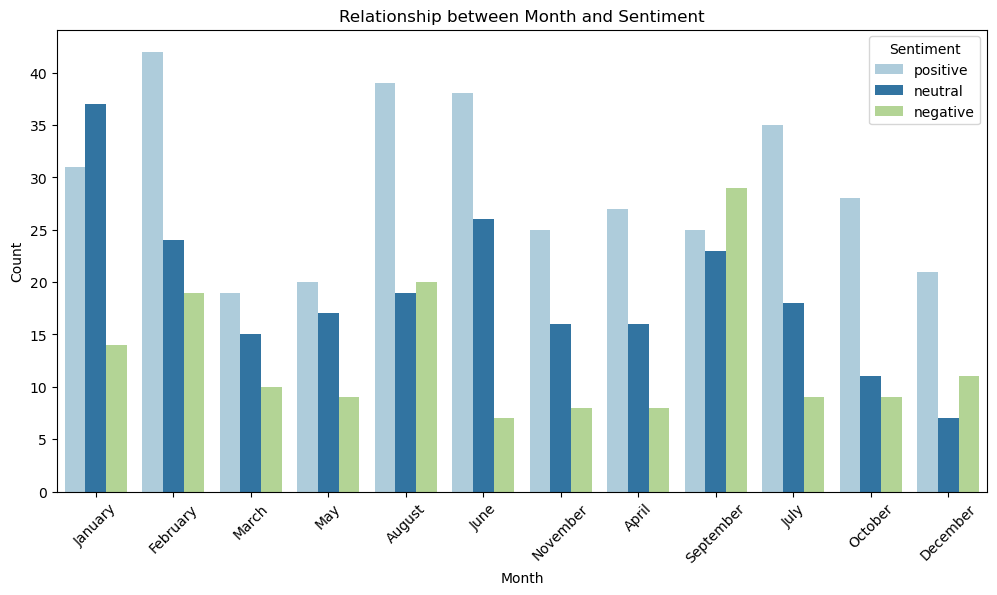

In [40]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Day Of Weeek

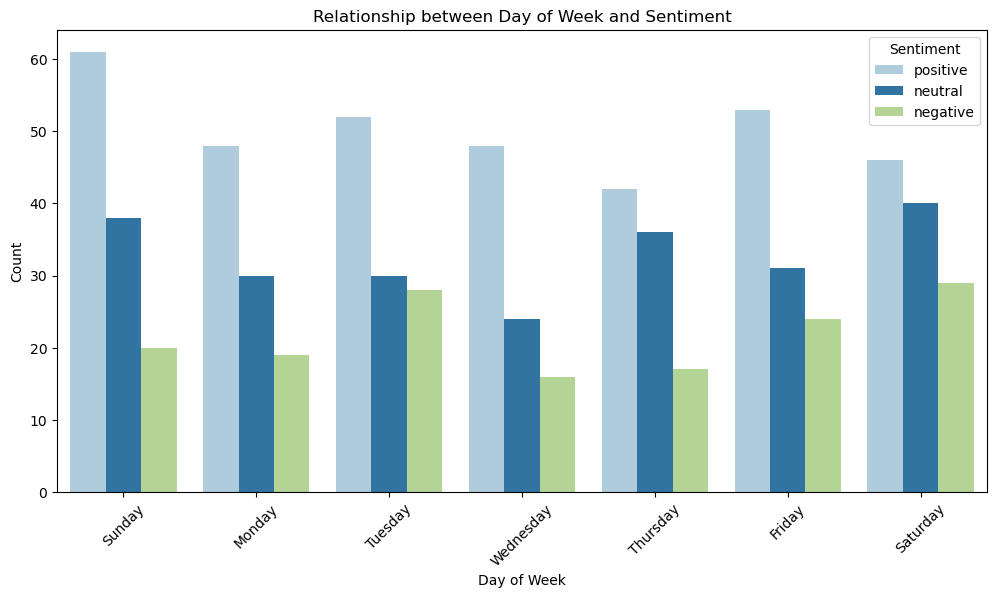

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Common Words

In [42]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,43
1,life,37
2,challeng,34
3,joy,31
4,danc,30
5,day,29
6,feel,29
7,like,28
8,dream,28
9,moment,27


### Positive Common Words

In [43]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,joy,30
1,friend,24
2,laughter,24
3,new,21
4,challeng,20
5,life,20
6,hope,20
7,dream,20
8,embrac,19
9,like,19


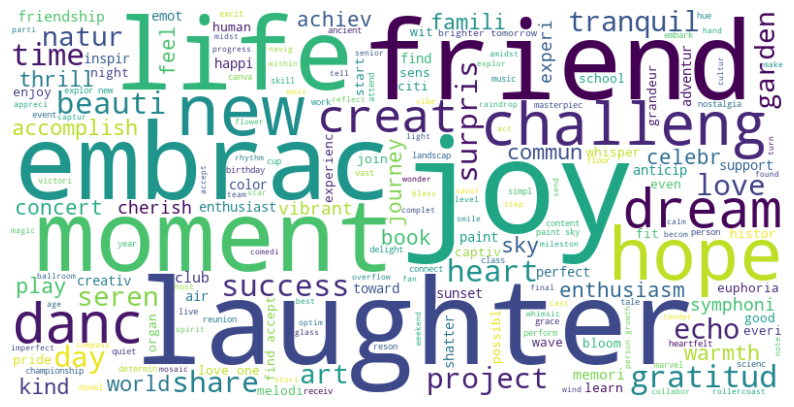

In [46]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative Common Words

In [48]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')


,Common_words,count
0,despair,14
1,lost,14
2,emot,13
3,feel,11
4,bitter,10
5,storm,10
6,day,9
7,like,9
8,grief,8
9,heart,8


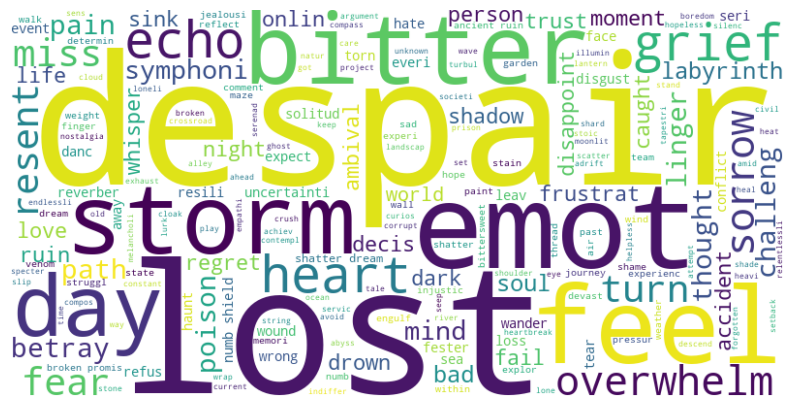

In [49]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()